In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


Links of resources:  
Zenodo paper: https://zenodo.org/record/5109574#.Y-kusS9aY4g  
ARPA Piemonte: https://www.arpa.piemonte.it/rischinaturali/accesso-ai-dati/annali_meteoidrologici/annali-meteo-idro/banca-dati-meteorologica.html  
IT-SNOW Zenodo paper: https://zenodo.org/record/6861723#.Y_8WmS9aY4g  
ARPA Valle D'Aosta: https://cf.regione.vda.it/portale_dati.php  
ARPA Lombardia: https://www.arpalombardia.it/Pages/Meteorologia/Richiesta-dati-misurati.aspx

In [3]:
# needed to create tif files

!pip install geopandas
!pip install geocube
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 6.6 MB/s eta 0:00:00


In [4]:
!pip install cffi
!pip install ecmwflibs
!pip install eccodes
!pip install cfgrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6944 sha256=cbbeedbe848e9b4497b996d786b69110380b931f4388527716f60f184a0e1630
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597d6a262803c0fcf2ba7c2c3
Successfully built findlibs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eccodes: filename=eccodes-1.5.2-py3-none-any.whl size=40545 sha256=7028ae4fd82589bbbc160c6e12adb5369fdcf94371c4774dc5592779337c2683
  Stored in directory: /root/.cache/pip/wheels/30/a8/9b/b80ae7683c2187d95eab008b4c57a5a57c50836aef413262a5
Successfully built eccodes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.0 MB/s eta 0:00:00


In [5]:
import rioxarray as xr
import xarray
import numpy as np
import pandas as pd
import glob
from datetime import datetime as datetime
from datetime import timedelta
from math import isnan
pd.options.mode.chained_assignment = None

In [6]:
snow_folder = "snow/"

START = datetime.strptime("2000-01-03", "%Y-%m-%d") # one year before the first VHI value (2001/01/05)
END = datetime.strptime("2019-12-31", "%Y-%m-%d")
weeks = pd.date_range(start=START, end=END, freq = '8D') # 8 days weeks in line with VHI target data
dates_8days = pd.date_range(start=START, end=END, freq = '8D')

num_months = len(pd.date_range(START, END,freq='MS'))
num_days = (END - START).days
num_weeks = len(weeks)
print(num_months)
print(num_weeks)
print(num_days)

239
913
7302


### Functions

In [ ]:
# compute the mean of not nan values
def meanNotNans(HS_list):

  # snow data values grouped by 8 days
  sublists = [HS_list[i:i + 8] for i in range(0, num_days, 8)]
  result = []
  for l in sublists:

    if (len(l) != 0):
      # for each week take the mean value if at least one not null is present, otherwise nan
      result.append(sum(l)/len(l))
    else:
      result.append(float('nan'))

  return result

In [ ]:
def create_df_stations_as_columns(all_stations_df, feature_name):

  station_names = all_stations_df['Name'].to_numpy()

  feature_df = pd.DataFrame(columns = station_names)
  feature_df.insert(0, 'Date', all_stations_df['Date'].unique())

  # add snow values
  for name in station_names:

    new_col = all_stations_df[all_stations_df['Name'] == name][feature_name]
    new_col.reset_index(inplace = True, drop = True)
    feature_df[name] = new_col

In [ ]:
from sklearn.impute import KNNImputer

def impute_missing_values_KNN(train_df, entire_df):
  KNNimp = KNNImputer(n_neighbors = 2, weights="uniform")
  KNNimp.fit(train_df.values)
  entire_df[entire_df.columns] = KNNimp.transform(entire_df.values)
  return entire_df

In [ ]:
def compute_cyclostationary_mean_ARPA(df, START, END):

  ordered_df = df.sort_values(by=['date', 'Name'])
  ordered_df.reset_index(inplace = True, drop = True)

  dates_8days = pd.date_range(start=START, end=END + timedelta(days=1), freq = '8D')
  years = [date.year for date in dates_8days]
  weeks = [date.isocalendar()[1] for date in dates_8days]
  last_training_day = round(len(dates_8days)*0.6)

  ordered_df['year'] = np.repeat(years, len(ordered_df['Name'].unique()))
  ordered_df['week'] = np.repeat(weeks, len(ordered_df['Name'].unique()))
  ordered_df = ordered_df[['date', 'y', 'x', 'year', 'week', 'mean']]

  train_df = ordered_df[ordered_df['date'] <= dates_8days[last_training_day]]

  weekoftheyar_mean = train_df.groupby(['week', 'y', 'x'])['mean'].mean()
  index = ordered_df.index
  ordered_df = pd.merge(ordered_df, weekoftheyar_mean, how='left', on=['week', 'y', 'x'],
                              suffixes=['','_weekoftheyear']).set_index(index)

  ordered_df['cyclostationary_mean'] = ordered_df['mean'] - ordered_df['mean_weekoftheyear']
  ordered_df.drop("mean_weekoftheyear", axis='columns', inplace = True)
  return ordered_df

In [7]:
# do the same aggregations done for temperature and cumulative rain

def computeAggregations(allCoord, csv_features_folder, csv_name, final_name, region, destination_folder):

    max_aggreg = 24

    if (allCoord == True):

        df = pd.read_csv(csv_features_folder + region + csv_name)
        df.drop('mean', axis = 1, inplace = True)
        df = df.rename(columns={'cyclostationary_mean':'cyclostationary_mean_HS'})

        # operations and save file

        df['date'] = pd.to_datetime(df['date'])

        for column in df.columns[-1:]:
            df[column + '_1w'] = df.apply(lambda x:df.loc[(df['date'] >= x.date+np.timedelta64(-8,'D')) &
                                          (df['date'] <= x.date) & (df['y'] == x.y) &
                                          (df['x'] == x.x), column].mean(), axis=1).values
            for i in range(4, max_aggreg+1, 4):
                if i != 20:
                    df[column + '_' + str(i) + 'w'] = df.apply(lambda x:df.loc[(df['date']>= x.date+np.timedelta64(-i*8,'D')) &
                                                  (df['date'] <= x.date) & (df['y'] == x.y) &
                                                  (df['x'] == x.x), column].mean(), axis=1).values

            i = 46
            df[column + '_' + str(i) + 'w'] = df.apply(lambda x:df.loc[(df['date']>= x.date+np.timedelta64(-i*8,'D')) &
                                                  (df['date'] <= x.date) & (df['y'] == x.y) &
                                                  (df['x'] == x.x), column].mean(), axis=1).values

        df.set_index('date').to_csv(destination_folder + region + final_name)

    else:

        df = pd.read_csv(csv_features_folder + region + csv_name)
        df.drop('mean', axis = 1, inplace = True)
        df = df.rename(columns={'cyclostationary_mean':'cyclostationary_mean_HS', 'Unnamed: 0':'date'})
        df['date'] = pd.to_datetime(df['date'])

        for column in df.columns[-1:]:
            df[column + '_1w'] = df.apply(lambda x:df.loc[(df['date'] >= x.date+np.timedelta64(-8,'D')) &
                                          (df['date'] <= x.date), column].mean(), axis=1).values
            for i in range(4, max_aggreg+1, 4):
                if i != 20:
                    df[column + '_' + str(i) + 'w'] = df.apply(lambda x:df.loc[(df['date']>= x.date+np.timedelta64(-i*8,'D')) &
                                                  (df['date'] <= x.date), column].mean(), axis=1).values
            # add 12 months aggregation for snow data
            i = 46
            df[column + '_' + str(i) + 'w'] = df.apply(lambda x:df.loc[(df['date']>= x.date+np.timedelta64(-i*8,'D')) &
             (df['date'] <= x.date), column].mean(), axis=1).values


        df.set_index('date').to_csv(destination_folder + region + final_name)

In [ ]:
# method for ARPA snow data

def compute_cyclostationary_mean_temporal_aggreg(df_station_means, last_training_day):

  df_station_means['year'] = [date.year for date in df_station_means['Date']]
  df_station_means['week'] = [date.isocalendar()[1] for date in df_station_means['Date']]

  train_df = df_station_means.iloc[:last_training_day,:]

  weekoftheyar_mean = train_df.groupby(['week'])['mean'].mean()
  index = df_station_means.index
  df_station_means = pd.merge(df_station_means, weekoftheyar_mean, how='left', on=['week'],
                        suffixes=['','_weekoftheyear']).set_index(index)

  df_station_means['cyclostationary_mean'] = df_station_means['mean'] - df_station_means['mean_weekoftheyear']
  df_station_means.drop("mean_weekoftheyear", axis='columns', inplace = True)

  max_aggreg = 24

  df_station_means.drop('mean', axis = 1, inplace = True)
  df_station_means = df_station_means.rename(columns={'cyclostationary_mean':'cyclostationary_mean_snow'})

  for column in df_station_means.columns[-1:]:
      df_station_means[column + '_1w'] = df_station_means.apply(lambda x:df_station_means.loc[(df_station_means['Date'] >= x.Date+np.timedelta64(-8,'D')) &
                                    (df_station_means['Date'] <= x.Date), column].mean(), axis=1).values
      for i in range(4, max_aggreg+1, 4):
          if i != 20:
              df_station_means[column + '_' + str(i) + 'w'] = df_station_means.apply(lambda x:df_station_means.loc[(df_station_means['Date']>= x.Date+np.timedelta64(-i*8,'D')) &
                                            (df_station_means['Date'] <= x.Date), column].mean(), axis=1).values

  return df_station_means

In [ ]:
# compute aggregations for each station at 1, 4, 6 months before
# the value in date x is given by the mean values 1,4,6 months bf

def compute_monthly_temporal_aggreg(HS_df):
  max_months_aggreg = 6

  HS_df['Date'] = pd.to_datetime(HS_df['Date'])
  HS_df_aggreg = HS_df.copy()

  for column in HS_df.columns[1:]:
    HS_df_aggreg[column + '_1m'] = HS_df_aggreg.apply(lambda x: HS_df_aggreg.loc[(HS_df_aggreg['Date'] >= x.Date+np.timedelta64(-1,'M')) &
                                    (HS_df_aggreg['Date'] <= x.Date), column].mean(), axis=1).values
    for i in range(4, max_months_aggreg+1, 2):
      HS_df_aggreg[column + '_' + str(i) + 'm'] = HS_df_aggreg.apply(lambda x: HS_df_aggreg.loc[(HS_df_aggreg['Date'] >= x.Date+np.timedelta64(-i,'M')) &
                                            (HS_df_aggreg['Date'] <= x.Date), column].mean(), axis=1).values

    HS_df_aggreg[column + '_12m'] = HS_df_aggreg.apply(lambda x: HS_df_aggreg.loc[(HS_df_aggreg['Date'] >= x.Date+np.timedelta64(-12,'M')) &
                                    (HS_df_aggreg['Date'] <= x.Date), column].mean(), axis=1).values

  return HS_df_aggreg

### Take latitude and longitude of stations - Zenodo paper

In [ ]:
df_stations_coord = pd.read_csv(snow_folder + "Zenodo_paper/meta_all.csv")

In [ ]:
# take only italian providers in the years we're studying

df_stations_coord = df_stations_coord.loc[(df_stations_coord['Provider'].str.startswith('IT')) &
                      ((df_stations_coord['HS_year_end'] >= START.year + 1) |
                       (df_stations_coord['HS_year_end'] == 'NaN'))]

df_stations_coord.reset_index(inplace = True, drop = True)

### Explore snow depth data - Zenodo paper

In [ ]:
#csv_snow_daily = ['snow/Zenodo_paper/data_daily_IT_LOMBARDIA.csv']
csv_snow_daily = glob.glob(snow_folder + "Zenodo_paper/data_daily*" + '*.csv')
csv_snow_daily

['snow/Zenodo_paper/data_daily_IT_BZ.csv',
 'snow/Zenodo_paper/data_daily_IT_FVG.csv',
 'snow/Zenodo_paper/data_daily_IT_LOMBARDIA.csv',
 'snow/Zenodo_paper/data_daily_IT_VDA_CF.csv',
 'snow/Zenodo_paper/data_daily_IT_TN.csv']

In [ ]:
# check availability of 8 days data

for idx, csv_filename in enumerate(csv_snow_daily):

  df = pd.read_csv(csv_filename)
  df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
  df_useful_dates = df.loc[(df['Date'] >= START) & (df['Date'] < END)]

  # merge to have also info about long, lat, elevation
  df_useful_dates_coord = pd.merge(df_useful_dates,
                                   df_stations_coord[['Name','Longitude', 'Latitude', 'Elevation', 'HS_year_start', 'HS_year_end']],
                                   on='Name', how='left')

  # filter stations with measurements (possibly also nan) for all the period
  df_useful_dates_coord = df_useful_dates_coord[(df_useful_dates_coord['HS_year_start'] <= 2000) &
                                                (df_useful_dates_coord['HS_year_end'] >= 2018)] # at most one year of data missing (2018)

  if idx == 0:
            complete_df_useful_dates_coord = df_useful_dates_coord
  else:
      complete_df_useful_dates_coord = pd.concat([complete_df_useful_dates_coord, df_useful_dates_coord], axis=0)

  # group by station name and create a column of HS (snow depth) daily values lists
  HS_by_Name = df_useful_dates_coord.groupby('Name')['HS_after_gapfill'].apply(list).reset_index(name="HS_after_gapfill")

  # take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
  HS_by_Name['HS_after_gapfill_avg8d'] = HS_by_Name['HS_after_gapfill'].apply(lambda l: meanNotNans(l))

  # count the percentage of weeks with at least one valid value
  HS_by_Name['notNan%'] = HS_by_Name['HS_after_gapfill_avg8d'].apply(lambda l: sum(~np.isnan(l))/num_weeks*100)

  df_useful_dates_coord = df_useful_dates_coord.merge(HS_by_Name[['Name', 'notNan%']], on = 'Name')

  # take only stations with a not Nan percentage greater than 48%
  if (idx == 0):
    df_best_stations_noPiemonte = df_useful_dates_coord.loc[df_useful_dates_coord['notNan%']>48]
  else:
    df_best_stations_noPiemonte = pd.concat([df_best_stations_noPiemonte, df_useful_dates_coord.loc[df_useful_dates_coord['notNan%']>48]])

  print("The percentage of not null snow depth 8 days data in " + csv_filename[19:len(csv_filename)-4] + " is \n")
  print(round(HS_by_Name[['Name', 'notNan%']],2))
  print("\n")

The percentage of not null snow depth 8 days data in ata_daily_IT_BZ is 

                                      Name  notNan%
0                     Anterivo_Osservatore    94.74
1          Anterselva_di_Mezzo_Osservatore    99.01
2                     Bronzolo_Osservatore    95.62
3              Casere_di_Fuori_Osservatore    94.19
4           Diga_di_Gioveretto_Osservatore    99.45
5                Diga_di_Neves_Osservatore    97.59
6             Diga_di_Valdaora_Osservatore    99.34
7                Diga_di_Vizze_Osservatore    99.23
8              Diga_di_Zoccolo_Osservatore    99.34
9             Favogna_di_sotto_Osservatore    94.96
10            Fie_allo_Sciliar_Osservatore    98.47
11                          Fontana_Bianca    99.56
12                    Fortezza_Osservatore    98.03
13                     Fundres_Osservatore    99.45
14           La_Villa_in_Badia_Osservatore    99.45
15                  Lago_Verde_Osservatore    62.21
16                     Lazfons_Osservatore

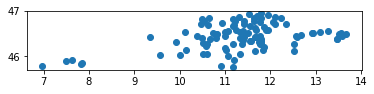

In [ ]:
import geopandas as gpd
from geocube.api.core import make_geocube

df_for_tif = complete_df_useful_dates_coord.groupby(['Latitude', 'Longitude']).first()
df_for_tif.reset_index(inplace = True)

gdf = gpd.GeoDataFrame(
    df_for_tif,
    geometry=gpd.points_from_xy(df_for_tif.Longitude, df_for_tif.Latitude)
)

gdf.plot() # first image hereunder

geotif_file = "/tmp/raster.tif"
out_grd = make_geocube(
    vector_data=gdf,
    measurements=["Elevation"],
    resolution=(-0.05, 0.05)
)

out_grd["Elevation"].rio.to_raster("all_stations_Zenodo.tif")

## Explore snow depth data - ARPA Piemonte

coordinate system: UTM zone 32N / WSG 84, EPSG:32632

In [ ]:
csv_snow_daily = glob.glob(snow_folder + "Piemonte/" + '*.csv')
csv_snow_daily

['snow/Piemonte/ACCEGLIO_giornalieri_1989_2022.csv',
 'snow/Piemonte/ALBANO VERCELLESE_giornalieri_1988_2022.csv',
 'snow/Piemonte/ALPE CHEGGIO_giornalieri_1996_2022.csv',
 'snow/Piemonte/ALPE DEVERO_giornalieri_1991_2022.csv',
 'snow/Piemonte/ANDRATE PINALBA_giornalieri_1999_2022.csv',
 'snow/Piemonte/A.CAVALLI_giornalieri_1990_2022.csv',
 'snow/Piemonte/LAGO CAMPOSECCO_giornalieri_1990_2022.csv',
 'snow/Piemonte/ARGENTERA_giornalieri_1996_2022.csv',
 'snow/Piemonte/BARCENISIO_giornalieri_1994_2022.csv',
 'snow/Piemonte/BOCCHETTA DELLE PISSE_giornalieri_1988_2022.csv',
 'snow/Piemonte/BOVES_giornalieri_1988_2022.csv',
 'snow/Piemonte/BRA_giornalieri_1993_2022.csv',
 'snow/Piemonte/CAMPARIENT_giornalieri_1999_2022.csv',
 'snow/Piemonte/CAPANNE MARCAROLO_giornalieri_1989_2022.csv',
 'snow/Piemonte/CASTELMAGNO_giornalieri_1996_2022.csv',
 'snow/Piemonte/CHIAPPI_giornalieri_1990_2022.csv',
 'snow/Piemonte/CERESOLE REALE_giornalieri_1990_2022.csv',
 'snow/Piemonte/CERESOLE VILLA_giornalier

In [ ]:
# check availability of 8 days data

from functools import reduce
# create a unique dataframe for all the available stations
for idx, csv_filename in enumerate(csv_snow_daily):

  df = pd.read_csv(csv_filename, sep=";")
  df.drop(list(df.filter(regex = 'Unnamed')), axis = 1, inplace = True)
  df['Data'] = pd.to_datetime(df['Data'], format="%d/%m/%Y")
  df_useful_dates = df.loc[(df['Data'] >= START) & (df['Data'] < END)]
  # take the part of the file name corresponding to the location name
  df_useful_dates['Name'] = csv_filename[14 : len(csv_filename) - 26]

  if (idx == 0):
    df_Piemonte = df_useful_dates
  else:
    df_Piemonte = pd.concat([df_Piemonte, df_useful_dates])

df_Piemonte.reset_index(inplace = True, drop = True)

# group by place name and create a column of snow depth daily values lists
snowdepth_by_name = df_Piemonte.groupby('Name')['Neve al Suolo ( cm )'].apply(list).reset_index(name="Neve al Suolo ( cm )")

# take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
snowdepth_by_name['Neve_al_Suolo_avg'] = snowdepth_by_name['Neve al Suolo ( cm )'].apply(lambda l: meanNotNans(l))

# count the percentage of weeks with at least one valid value
snowdepth_by_name['notNan%'] = snowdepth_by_name['Neve_al_Suolo_avg'].apply(lambda l: sum(~np.isnan(l))/num_weeks*100)

snow_8daysavg = reduce(lambda a, b: a+b, snowdepth_by_name['Neve_al_Suolo_avg'])

df_Piemonte = pd.DataFrame({'Data': np.tile(dates_8days, len(df_Piemonte['Name'].unique())),
                            'Name': np.repeat(sorted(snowdepth_by_name['Name'].unique()), num_weeks),
                            'Neve al Suolo ( cm )': snow_8daysavg, 'notNan%': np.repeat(snowdepth_by_name['notNan%'], num_weeks)})

# filter the ones with a not nan percentage greater than 78%
df_Piemonte_filtered = snowdepth_by_name[['Name', 'notNan%']].loc[snowdepth_by_name['notNan%']>78]
df_Piemonte_filtered.reset_index(inplace = True, drop = True)

In [ ]:
# coordinates and elevation info taken manually from ARPA Piemonte application

df_Piemonte_filtered.reset_index(inplace = True, drop = True)

df_Piemonte_filtered['Longitude'] = [339485, 452158, 341716, 414709, 385360, 409014,
                                    428799, 481594, 360081, 337713, 346542, 325037,
                                    352013, 395171, 429468, 450696, 456046, 360922,
                                    354154, 354538, 426562, 332611, 451147, 336009,
                                    419251, 362275, 420739, 351734, 418730, 345473,
                                    463371, 337765, 346648, 320252, 428948, 354420,
                                    398675, 336227, 334219, 335674, 332362, 361627]

df_Piemonte_filtered['Latitude'] = [4927741, 5031790, 5006231, 5080807, 4910099, 4950399,
                                     5064689, 4934453, 5033408, 4983090, 4959725, 4976566,
                                     4896634, 5032962, 4932880, 5142404, 5132835, 5024534,
                                     5035792, 5036613, 5101076, 4985398, 5136990, 4991102,
                                     5091486, 4946814, 5094227, 4934527, 5060065, 4941691,
                                     4929557, 4985989, 4974213, 4993819, 4914151, 5017741,
                                     4893945, 5002193, 4993018, 4973342, 4979728, 4896075]

df_Piemonte_filtered['Elevation'] = [1610, 155, 1525, 2410, 575, 285, 1515, 780,
                                     1581, 2150, 2294, 2200, 2305, 1240, 770,
                                     2453, 1226, 1215, 2283, 2304, 2325, 2280,
                                     2177, 1980, 1360, 1257, 2820, 2135, 1040,
                                     1575, 773, 1525, 1385, 1290, 610, 2659,
                                     1760, 2745, 1010, 1840, 2020, 1390]

df_Piemonte_filtered['Associated_region'] = ['Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Nord', 'Piemonte_Nord', 'Piemonte_Sud', 'Piemonte_Sud',
                                             'Piemonte_Nord', 'Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Sud', 'Piemonte_Sud', 'Piemonte_Nord',
                                             'Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Sud', 'Ticino', 'Ticino', 'Piemonte_Nord',
                                             'Piemonte_Nord', 'Piemonte_Nord', 'Ticino', 'Piemonte_Nord', 'Ticino', 'Piemonte_Nord',
                                             'Ticino', 'Piemonte_Sud', 'Ticino', 'Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Sud',
                                             'Piemonte_Sud', 'Piemonte_Sud', 'Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Sud', 'Piemonte_Nord',
                                             'Piemonte_Sud', 'Piemonte_Nord', 'Piemonte_Nord', 'Piemonte_Nord', 'Piemonte_Nord', 'Piemonte_Sud']

df_Piemonte_filtered['Provider'] = ["ARPA_PIEMONTE"] * len(df_Piemonte_filtered)
df_Piemonte_filtered

In [ ]:
# convert latitude and longitude from ARPA to the ref system we're using
import pyproj

latitude, longitude = df_Piemonte_filtered['Latitude'], df_Piemonte_filtered['Longitude']

ARPA_Piemonte_coord = pyproj.Proj(init='epsg:23032')
std_coord = pyproj.Proj(init='epsg:4326')

lat, lon = pyproj.transform(ARPA_Piemonte_coord, std_coord, longitude, latitude)

In [ ]:
# take the best stations (>78% valid data), adding lat, lon and associated region
df_Piemonte_best = df_Piemonte[df_Piemonte['Name'].isin(df_Piemonte_filtered['Name'])]
df_Piemonte_best['Latitude'] = np.repeat(lat, num_weeks)
df_Piemonte_best['Longitude'] = np.repeat(lon, num_weeks)
df_Piemonte_best['Associated_region'] = np.repeat(df_Piemonte_filtered['Associated_region'].values, num_weeks)
df_Piemonte_best

In [ ]:
region = "Ticino" # change here to take a different region
df_Piemonte_region = df_Piemonte_best[df_Piemonte_best['Associated_region'] == region]

df_Piemonte = df_Piemonte_region.rename(columns={'Latitude':'y', 'Longitude': 'x', 'Neve al Suolo ( cm )': 'mean', 'Data': 'date'})
df_Piemonte.reset_index(inplace = True, drop = True)
ARPA_csv_files_dir = "snow/ARPA_csv/"

# do imputation to manage nan values

# create a dataframe with snow values for each station
station_names = df_Piemonte['Name'].unique()
df_stations_as_columns = pd.DataFrame(columns = station_names)
df_stations_as_columns.insert(0, 'Date', df_Piemonte['date'].unique())

# add snow values
for name in station_names:
  new_col = df_Piemonte[df_Piemonte['Name'] == name]['mean']
  new_col.reset_index(inplace = True, drop = True)
  df_stations_as_columns[name] = new_col

last_training_date = '2009-12-29'
last_training_index = df_stations_as_columns.index[df_stations_as_columns['Date'] == last_training_date][0]

df_stations_as_columns.iloc[:,1:] = impute_missing_values_KNN(df_stations_as_columns.iloc[:last_training_index,1:],
                                                              df_stations_as_columns.iloc[:,1:])

# take the new values of columns and put them as a single column in the old dataframe
df_Piemonte['mean'] = pd.concat([df_stations_as_columns[col] for col in df_stations_as_columns.iloc[:, 1:].columns.tolist()], axis = 0, ignore_index=True)

df_Piemonte = compute_cyclostationary_mean_ARPA(df_Piemonte, START, END)

In [ ]:
df_Piemonte.set_index('date').to_csv(ARPA_csv_files_dir + region + "_snowDepth_allCoord.csv")

In [ ]:
# add aggregations to cyclostationary values

computeAggregations(True, ARPA_csv_files_dir, "_snowDepth_allCoord.csv", "_snowDepth_aggreg_allCoord.csv")

In [ ]:
# compute the mean for all the stations and a new csv without all coord

means = df_stations_as_columns.mean(axis=1)

df_stations_means = pd.DataFrame()
df_stations_means.insert(0, 'Date', df_stations_as_columns['Date'].unique())
df_stations_means.insert(1, 'mean', means)

df_stations_means = compute_cyclostationary_mean_temporal_aggreg(df_stations_means, last_training_index)

df_stations_means.set_index('Date').to_csv(ARPA_csv_files_dir + "snow_" + region + "_with_aggreg_KNN5.csv")

<ipython-input-31-128d42674ea0>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  means = df_stations_as_columns.mean(axis=1)


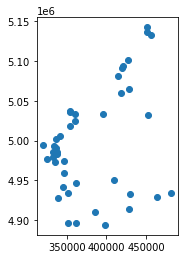

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube

df_for_tif = df_Piemonte_filtered.groupby(['Latitude', 'Longitude']).first()
df_for_tif.reset_index(inplace = True)

gdf = gpd.GeoDataFrame(
    df_for_tif,
    geometry=gpd.points_from_xy(df_for_tif.Longitude, df_for_tif.Latitude)
)

gdf.plot()

geotif_file = "/tmp/raster.tif"
out_grd = make_geocube(
    vector_data=gdf,
    measurements=["Elevation"],
    resolution=(-3000, 3000)
)

out_grd["Elevation"].rio.to_raster("Piemonte_stations.tif")

## Explore snow depth data - ARPA Valle D'Aosta

In [ ]:
csv_snow_daily = glob.glob(snow_folder + "Aosta/" + '*.csv')
csv_snow_daily

['snow/Aosta/Dati_1080-Altezza neve al suolo_Chamois - Lac de Lou.csv',
 'snow/Aosta/Dati_1040-Altezza neve al suolo_Bionaz - Place Moulin.csv',
 'snow/Aosta/Dati_3590-Altezza neve al suolo_Valtournenche - Breuil Cervinia.csv',
 'snow/Aosta/Dati_1530-Altezza neve al suolo_Rhêmes-Saint-Georges - Feleumaz.csv',
 'snow/Aosta/Dati_1340-Altezza neve al suolo_La Thuile - La Grande Tête.csv',
 'snow/Aosta/Dati_3110-Altezza neve al suolo_Courmayeur - Dolonne.csv',
 'snow/Aosta/Dati_3080-Altezza neve al suolo_Nus - Saint-Barthélemy - Osservatorio.csv',
 'snow/Aosta/Dati_4090-Altezza neve al suolo_Saint-Christophe - Aeroporto.csv',
 'snow/Aosta/Dati_3070-Altezza neve al suolo_Valsavarenche - Pont.csv',
 'snow/Aosta/Dati_3060-Altezza neve al suolo_Rhêmes-Notre-Dame - Chaudanne.csv',
 'snow/Aosta/Dati_3050-Altezza neve al suolo_Champorcher - Petit-Mont-Blanc.csv',
 'snow/Aosta/Dati_3040-Altezza neve al suolo_Gressoney-Saint-Jean - Bieltschocke.csv',
 'snow/Aosta/Dati_1710-Altezza neve al suolo_Val

In [ ]:
import pandas as pd
import os
from datetime import datetime

# create new csv formatted in a more convenient way for our purposes, delete the original ones
for csv_name in csv_snow_daily:
  df = pd.read_csv(csv_name, skiprows = 7, encoding = "iso8859_16", sep = "\t",
                   names = ['Date', 'SnowDepth'])

  # take the station name from where it is located in the original csv
  info = pd.read_csv(csv_name, nrows = 7, encoding = "iso8859_16", on_bad_lines='skip')
  station_name = info.iloc[1:2,:].values[0]
  station_name = str(station_name)[12:-2]

  #df.to_csv(csv_name.replace('.csv', '_' + station_name + '.csv'))
  #os.remove(csv_name)

In [ ]:
# create a unique dataframe for all the available stations
for idx, csv_filename in enumerate(csv_snow_daily):

  df = pd.read_csv(csv_filename)
  df.drop(list(df.filter(regex = 'Unnamed')), axis = 1, inplace = True)
  df['Date'] = pd.to_datetime(df['Date'], format="%Y/%m/%d")
  df_useful_dates = df.loc[(df['Date'] >= START) & (df['Date'] < END)]
  # take the part of the file name corresponding to the location name
  df_useful_dates['Name'] = csv_filename[43 : -4]

  if (idx == 0):
    df_Aosta = df_useful_dates
  else:
    df_Aosta = pd.concat([df_Aosta, df_useful_dates])

df_Aosta.reset_index(inplace = True, drop = True)
df_Aosta = df_Aosta.replace(',','.', regex=True)
df_Aosta['SnowDepth'] = df_Aosta['SnowDepth'].astype(float)

# group by place name and create a column of HS daily values lists
HS_by_Name = df_Aosta.groupby('Name')['SnowDepth'].apply(list).reset_index(name="SnowDepth")

# take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
HS_by_Name['SnowDepth_avg'] = HS_by_Name['SnowDepth'].apply(lambda l: meanNotNans(l))

# count the percentage of weeks with at least one valid value
HS_by_Name['notNan%'] = HS_by_Name['SnowDepth_avg'].apply(lambda l: sum(~np.isnan(l))/num_weeks*100)

In [ ]:
# taka VDA values from Zenodo paper
df_Aosta_Zenodo = pd.read_csv('snow/Zenodo_paper/data_daily_IT_VDA_CF.csv')
df_Aosta_Zenodo['Date'] = pd.to_datetime(df_Aosta_Zenodo['Date'], format="%Y-%m-%d")
df_Aosta_Zenodo = df.loc[(df_Aosta_Zenodo['Date'] >= START) & (df_Aosta_Zenodo['Date'] < END)]

# for the common stations put the name in the same format as for ARPA
df_Aosta_Zenodo['Name'].replace("Bionaz_Place_Moulin", "Bionaz - Place Moulin", inplace = True)
df_Aosta_Zenodo['Name'].replace("Courmayeur_Dolonne", "Courmayeur - Dolonne", inplace = True)
df_Aosta_Zenodo['Name'].replace("Gressoney_La_Trinite_Eselbode", "Gressoney-la-Trinité - Eselbode", inplace = True)
df_Aosta_Zenodo['Name'].replace("Gressoney_La_Trinite_Gabiet", "Gressoney-la-Trinité - Gabiet", inplace = True)

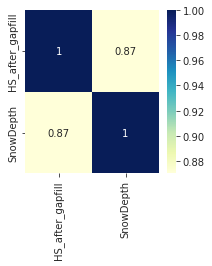

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# check correlation among Zenodo and ARPA values of snowh depth
common_stations = df_Aosta_Zenodo[df_Aosta_Zenodo["Name"].isin(np.intersect1d(df_Aosta_Zenodo["Name"].unique(), df_Aosta["Name"].unique()))]
common_stations.reset_index(inplace = True, drop = True)
complete_Aosta_data = pd.merge(common_stations, df_Aosta, on=['Name', 'Date'], how='outer')

cormat = complete_Aosta_data[["HS_after_gapfill", "SnowDepth"]].corr()
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(round(cormat,2), annot=True, ax=ax, cmap="YlGnBu")
ax.set_facecolor('white')
sns.set_style('ticks')

In [ ]:
# merge together stations of ARPA valle d'Aosta and data from Zenodo paper
# take the available values from both, average them when only one is present
# needed in order to cover the entire period 2001-2019

complete_Aosta_data = pd.merge(df_Aosta_Zenodo, df_Aosta, on=['Name', 'Date'], how='outer')
complete_Aosta_data['SnowDepth_merged'] = complete_Aosta_data[['HS_after_gapfill', 'SnowDepth']].apply(lambda row: np.nan if np.isnan(row['HS_after_gapfill']) and
                                                                             np.isnan(row['SnowDepth']) else row.mean(), axis=1)

stations_from_2000 = complete_Aosta_data.loc[complete_Aosta_data['Date'] == START]['Name'].unique()
stations_until_2019 = complete_Aosta_data.loc[complete_Aosta_data['Date'] == datetime.strptime("2019-12-30", "%Y-%m-%d")]['Name'].unique()
stations_entire_range = np.intersect1d(stations_from_2000, stations_until_2019)

df_stations_entire_range_Aosta = complete_Aosta_data.loc[complete_Aosta_data['Name'].isin(stations_entire_range)]
df_stations_entire_range_Aosta.sort_values(by=['Name', 'Date'], inplace = True)
df_stations_entire_range_Aosta.reset_index(inplace = True, drop = True)

In [ ]:
# group by place name and create a column of SnowDepth daily values lists
snow_depth_by_name = df_stations_entire_range_Aosta.groupby('Name')['SnowDepth_merged'].apply(list).reset_index(name="SnowDepth_merged")

# take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
snow_depth_by_name['SnowDepth_avg'] = snow_depth_by_name['SnowDepth_merged'].apply(lambda l: meanNotNans(l))

# count the percentage of weeks with at least one valid value
snow_depth_by_name['notNan%'] = snow_depth_by_name['SnowDepth_avg'].apply(lambda l: sum(~np.isnan(l))/num_weeks*100)

In [ ]:
# concatenate the lists of SnowDepth_avg list in a unique one that will be the new column of values
from functools import reduce
HS_8daysavg = reduce(lambda a, b: a+b, snow_depth_by_name['SnowDepth_avg'])

df_Aosta = pd.DataFrame({'Data': np.tile(dates_8days, len(stations_entire_range)),
                            'Name': np.repeat(sorted(stations_entire_range), num_weeks),
                            'SnowDepth': HS_8daysavg, 'notNan%': np.repeat(snow_depth_by_name['notNan%'], num_weeks)})

Elevation = [1979, 1200, 1642, 2379, 1690, 545]
Latitude = [45.9, 45.794, 45.831, 45.852, 45.579, 45.739]
Longitude = [7.491, 6.966, 7.826, 7.849, 7.123, 7.363]

df_Aosta_8days = pd.DataFrame({'Date': np.tile(dates_8days, len(stations_entire_range)),
                            'Name': np.repeat(sorted(stations_entire_range), num_weeks),
                            'SnowDepth': HS_8daysavg, 'notNan%': np.repeat(snow_depth_by_name['notNan%'], num_weeks),
                            'Elevation': np.repeat(Elevation, num_weeks), 'Latitude': np.repeat(Latitude, num_weeks),
                            'Longitude': np.repeat(Longitude, num_weeks)})

snow_depth_by_name[['Name', 'notNan%']].loc[snow_depth_by_name['notNan%']>48]
df_Aosta_8days.reset_index(inplace = True, drop = True)

In [ ]:
region = 'Dora'
# remove the last two stations (few valid data)
df_stations_entire_range_Aosta_valid = df_Aosta_8days.loc[~df_Aosta_8days['Name'].isin(df_Aosta_8days['Name'].unique()[-2:])]

# create a dataframe with snow values for each station
station_names_Dora = df_stations_entire_range_Aosta_valid['Name'].unique()

df_stations_as_columns = pd.DataFrame(columns = station_names_Dora)
df_stations_as_columns.insert(0, 'Date', df_stations_entire_range_Aosta_valid['Date'].unique())

# add snow values
for name in station_names_Dora:

  new_col = df_stations_entire_range_Aosta_valid[df_stations_entire_range_Aosta_valid['Name'] == name]['SnowDepth']
  new_col.reset_index(inplace = True, drop = True)
  df_stations_as_columns[name] = new_col

# impute the missing values with KNN
last_training_date = '2009-12-29'
last_training_index = df_stations_as_columns.index[df_stations_as_columns['Date'] == last_training_date][0]

df_stations_as_columns.iloc[:,1:] = impute_missing_values_KNN(df_stations_as_columns.iloc[:last_training_index,1:], df_stations_as_columns.iloc[:,1:])

In [ ]:
df_stations_entire_range_Aosta_valid = df_stations_entire_range_Aosta_valid.rename(columns={'Latitude':'y', 'Longitude': 'x', 'SnowDepth': 'mean', 'Date': 'date'})
df_stations_entire_range_Aosta_valid.reset_index(inplace = True, drop = True)

ARPA_csv_files_dir = "snow/ARPA_csv/"

df_stations_entire_range_Aosta_valid['mean'] = pd.concat([df_stations_as_columns[col] for col in df_stations_as_columns.iloc[:, 1:].columns.tolist()], axis = 0, ignore_index=True)
df_stations_entire_range_Aosta_valid = compute_cyclostationary_mean_ARPA(df_stations_entire_range_Aosta_valid, START, END)

In [ ]:
df_stations_entire_range_Aosta_valid.set_index('date').to_csv(ARPA_csv_files_dir + region + "_snowDepth_allCoord.csv")

computeAggregations(True, ARPA_csv_files_dir, "_snowDepth_allCoord.csv", "_snowDepth_aggreg_allCoord.csv")

In [ ]:
means = df_stations_as_columns.mean(axis=1)

HS_df_station_means = pd.DataFrame()
HS_df_station_means.insert(0, 'Date', df_stations_as_columns['Date'].unique())
HS_df_station_means.insert(1, 'mean', means)

HS_df_station_means = compute_cyclostationary_mean_temporal_aggreg(HS_df_station_means, last_training_index)

HS_df_station_means.set_index('Date').to_csv(ARPA_csv_files_dir + "snow_" + region + "_with_aggreg_KNN.csv")

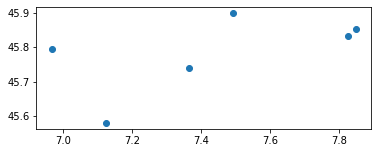

In [ ]:
import geopandas as gpd
from geocube.api.core import make_geocube

df_for_tif = df_Aosta_8days.groupby(['Latitude', 'Longitude']).first()
df_for_tif.reset_index(inplace = True)

gdf = gpd.GeoDataFrame(
    df_for_tif,
    geometry=gpd.points_from_xy(df_for_tif.Longitude, df_for_tif.Latitude)
)

gdf.plot()
out_grd = make_geocube(
    vector_data=gdf,
    measurements=["Elevation"],
    resolution=(-0.04, 0.04)
)

out_grd["Elevation"].rio.to_raster("Aosta_stations.tif")

## Explore snow depth data - ARPA Lombardia

### ARPA Lombardia + Zenodo stations - until 2018

In [ ]:
df = pd.read_csv('snow/Zenodo_paper/data_daily_IT_LOMBARDIA.csv')

In [ ]:
csv_snow_daily = glob.glob(snow_folder + "Lombardia/" + '*.csv')
csv_snow_daily

['snow/Lombardia/Valdisotto_Oga_S_Colombano.csv',
 'snow/Lombardia/Lanzada_Palù.csv',
 'snow/Lombardia/Aprica.csv',
 'snow/Lombardia/Ponte_di_Legno_Case_Pirli.csv',
 'snow/Lombardia/Edolo_Pantano_d_Avio.csv',
 'snow/Lombardia/Carona_Carisole.csv',
 'snow/Lombardia/Gerola_Alta_Pescegallo.csv']

In [ ]:
START = datetime.strptime("2000-01-03", "%Y-%m-%d")
END = datetime.strptime("2018-12-31", "%Y-%m-%d")
weeks = pd.date_range(start=START, end=END, freq = '8D') # 8 days weeks in line with VHI target data
dates_8days = pd.date_range(start=START, end=END, freq = '8D')
num_weeks_2018 = len(weeks)
num_days = (END - START).days

In [ ]:
# merge Ponte di Legno (starting from 2004) with values from Zenodo paper

df = pd.read_csv('snow/Zenodo_paper/data_daily_IT_LOMBARDIA.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%Y/%m/%d")
df_Ponte_Legno_00_04 = df[df['Name'] == "Ponte_di_Legno"].loc[(df['Date'] >= START) &
                                                              (df['Date'] < datetime.strptime("2004-01-01", "%Y-%m-%d"))]
df_Ponte_Legno_00_04.rename(columns={'HS_after_gapfill': 'SnowDepth'}, inplace = True)

ARPA_df_Ponte_Legno = pd.read_csv('snow/Lombardia/Ponte_di_Legno_Case_Pirli.csv')
ARPA_df_Ponte_Legno['Date'] = pd.to_datetime(ARPA_df_Ponte_Legno['Data-Ora'], format="%Y/%m/%d")
ARPA_df_Ponte_Legno = ARPA_df_Ponte_Legno.loc[ARPA_df_Ponte_Legno['Date'] < END]
ARPA_df_Ponte_Legno.rename(columns={'Valore Medio Giornaliero': 'SnowDepth'}, inplace = True)
ARPA_df_Ponte_Legno = ARPA_df_Ponte_Legno[['Date', 'SnowDepth']]

complete_df_Ponte_Legno = pd.merge(df_Ponte_Legno_00_04[['Date', 'SnowDepth']],
                                   ARPA_df_Ponte_Legno, on=['Date', 'SnowDepth'], how='outer')

complete_df_Ponte_Legno['Name'] = 'Ponte_di_Legno'

In [ ]:
from functools import reduce

# create a unique dataframe for all the available stations
for idx, csv_filename in enumerate(csv_snow_daily):
  if csv_filename == 'snow/Lombardia/Ponte_di_Legno_Case_Pirli.csv':
    continue

  df = pd.read_csv(csv_filename)
  df['Date'] = pd.to_datetime(df['Data-Ora'], format="%Y/%m/%d")
  df.drop('Data-Ora', axis = 1, inplace = True)
  df = df.loc[df['Date'] < END]            # to end in 2018 instead of 2019

  # take the part of the file name corresponding to the location name
  df['Name'] = csv_filename[15 : -4]

  if (idx == 0):
    df_Lombardia = df
  else:
     df_Lombardia = pd.concat([df_Lombardia, df])

df_Lombardia.rename(columns={'Valore Medio Giornaliero': 'SnowDepth'}, inplace = True)
df_Lombardia = pd.concat([df_Lombardia[['Date', 'Name', 'SnowDepth']], complete_df_Ponte_Legno])
df_Lombardia.reset_index(inplace = True, drop = True)
df_Lombardia.replace(-999, np.NaN, inplace=True) # missing or invalid value

# group by place name and create a column of HS daily values lists
snow_depth_by_name = df_Lombardia.groupby('Name')['SnowDepth'].apply(list).reset_index(name="SnowDepth")

# take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
snow_depth_by_name['SnowDepth_avg'] = snow_depth_by_name['SnowDepth'].apply(lambda l: meanNotNans(l))

# count the percentage of weeks with at least one valid value
snow_depth_by_name['notNan%'] = snow_depth_by_name['SnowDepth_avg'].apply(lambda l: sum(~np.isnan(l))/num_weeks_2018*100)

In [ ]:
# concatenate the lists of SnowDepth_avg list in a unique one that will be the new column of values
snow_depth_8daysavg = reduce(lambda a, b: a+b, snow_depth_by_name['SnowDepth_avg'])

# df = pd.read_csv('AnagraficaStazioni_WEB.csv')

Elevation = [1950, 1954, 2108, 1875, 2151, 1640, 2300]
# coordinates: WGS84
UTM_Nord = [5109097.71, 5098634, 5114768.88, 5097116.7, 5126972.46, 5128139.55, 5145272.25]
UTM_Est = [588704.71, 561423, 613679.81, 544202.3, 568128.62, 616030.57, 600293.93]

# after conversion
Latitude = [46.127909, 46.036741, 46.175232, 46.024413, 46.291124, 46.295129, 46.451785]
Longitude = [10.147144, 9.792694, 10.471693, 9.570024, 9.883413, 10.505424, 10.304829]

df_Lombardia_8days = pd.DataFrame({'Data': np.tile(dates_8days, len(df_Lombardia['Name'].unique())),
                            'Name': np.repeat(sorted(df_Lombardia['Name'].unique()), num_weeks_2018),
                            'SnowDepth': snow_depth_8daysavg, 'notNan%': np.repeat(snow_depth_by_name['notNan%'], num_weeks_2018),
                            'Elevation': np.repeat(Elevation, num_weeks_2018), 'Latitude': np.repeat(Latitude, num_weeks_2018),
                            'Longitude': np.repeat(Longitude, num_weeks_2018)})
df_Lombardia_8days.reset_index(inplace = True, drop = True)

In [ ]:
stations_Lombardia_2018 = pd.concat([df_Lombardia_8days, df_Lombardia_Zenodo_8days])

In [ ]:
stations_Lombardia_2018.groupby('Name').first()

,Data,SnowDepth,notNan%,Elevation,Latitude,Longitude
Name,,,,,,
Aprica,2000-01-03,63.8000,75.806452,1950.0,46.127909,10.147144
Aprica_Magnolta,2000-01-03,68.7500,49.078341,1870.0,46.132157,10.139462
Bormio_2000,2000-01-03,54.1250,53.801843,2010.0,46.440726,10.389955
Campo_Moro,2000-01-03,80.1250,63.940092,1970.0,46.303033,9.927422
Carona_Carisole,2000-01-03,60.3500,75.345622,1954.0,46.036741,9.792694
Edolo_Pantano_d_Avio,2000-01-03,63.8750,77.073733,2108.0,46.175232,10.471693
Gerola_Alta_Pescegallo,2000-01-03,64.8250,78.917051,1875.0,46.024413,9.570024
Lanzada_Palù,2000-01-03,88.2875,80.529954,2151.0,46.291124,9.883413
Livigno_S_Rocco,2000-01-03,32.7500,80.069124,1875.0,46.523450,10.126005


In [ ]:
df_stations_until_2018_Adda = stations_Lombardia_2018.loc[~stations_Lombardia_2018['Name'].isin(['Edolo_Pantano_d_Avio', 'Ponte_di_Legno', 'Livigno_S_Rocco'])]
df_stations_until_2018_Adda.reset_index(inplace = True, drop = True)
df_stations_until_2018_Adda.groupby('Name').first()

,Data,SnowDepth,notNan%,Elevation,Latitude,Longitude
Name,,,,,,
Aprica,2000-01-03,63.8000,75.806452,1950.0,46.127909,10.147144
Aprica_Magnolta,2000-01-03,68.7500,49.078341,1870.0,46.132157,10.139462
Bormio_2000,2000-01-03,54.1250,53.801843,2010.0,46.440726,10.389955
Campo_Moro,2000-01-03,80.1250,63.940092,1970.0,46.303033,9.927422
Carona_Carisole,2000-01-03,60.3500,75.345622,1954.0,46.036741,9.792694
Gerola_Alta_Pescegallo,2000-01-03,64.8250,78.917051,1875.0,46.024413,9.570024
Lanzada_Palù,2000-01-03,88.2875,80.529954,2151.0,46.291124,9.883413
Lizzola,2000-01-03,100.0000,47.926267,1490.0,46.019528,10.004137
Madesimo,2000-01-03,55.5000,53.110599,1530.0,46.431452,9.353655


In [ ]:
df_stations_until_2018_Adda = df_stations_until_2018_Adda.rename(columns={'Latitude':'y', 'Longitude': 'x',
                                                                          'SnowDepth': 'mean', 'Data': 'date'})
# create a dataframe with snow values for each station
station_names_Adda = df_stations_until_2018_Adda['Name'].unique()
df_stations_as_columns = pd.DataFrame(columns = station_names_Adda)
df_stations_as_columns.insert(0, 'Date', df_stations_until_2018_Adda['date'].unique())

# add snow values
for name in station_names_Adda:

  new_col = df_stations_until_2018_Adda[df_stations_until_2018_Adda['Name'] == name]['mean']
  new_col.reset_index(inplace = True, drop = True)
  df_stations_as_columns[name] = new_col

last_training_index = round(len(dates_8days)*0.6)

df_stations_as_columns.iloc[:,1:] = impute_missing_values_KNN(df_stations_as_columns.iloc[:last_training_index,1:],
                                                              df_stations_as_columns.iloc[:,1:])
# take the new values of columns and put them as a single column in the old dataframe

df_stations_until_2018_Adda['mean'] = pd.concat([df_stations_as_columns[col] for
                                                 col in df_stations_as_columns.iloc[:, 1:].columns.tolist()], ignore_index=True)

region = 'Adda'
ARPA_csv_files_dir = "snow/ARPA_csv/"

df_stations_until_2018_Adda = compute_cyclostationary_mean_ARPA(df_stations_until_2018_Adda, START, END)

In [ ]:
df_stations_until_2018_Adda.set_index('date').to_csv(ARPA_csv_files_dir + region + "_snowDepth_2018_allCoord.csv")

In [ ]:
computeAggregations(True, ARPA_csv_files_dir, "_snowDepth_allCoord.csv", "_snowDepth_2018_aggreg_allCoord.csv")

In [ ]:
# compute the mean for all the stations and a new csv without all coord
means = df_stations_as_columns.mean(axis=1)

df_stations_means = pd.DataFrame()
df_stations_means.insert(0, 'Date', df_stations_as_columns['Date'].unique())
df_stations_means.insert(1, 'mean', means)

df_stations_means = compute_cyclostationary_mean_temporal_aggreg(df_stations_means, last_training_index)

df_stations_means.set_index('Date').to_csv(ARPA_csv_files_dir + "snow_Adda_2018_with_aggreg_KNN.csv")

<ipython-input-73-ce649cf3d4fd>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  means = df_stations_as_columns.mean(axis=1)


### ARPA Lombardia stations only, until 2019

In [ ]:
START = datetime.strptime("2000-01-03", "%Y-%m-%d") # one year before the first VHI value (2001/01/05)
END = datetime.strptime("2019-12-31", "%Y-%m-%d")
weeks = pd.date_range(start=START, end=END, freq = '8D') # 8 days weeks in line with VHI target data
dates_8days = pd.date_range(start=START, end=END, freq = '8D')
num_weeks_2018 = len(weeks)
num_days = (END - START).days

In [ ]:
csv_snow_daily = glob.glob(snow_folder + "Lombardia/" + '*.csv')
csv_snow_daily

['snow/Lombardia/Valdisotto_Oga_S_Colombano.csv',
 'snow/Lombardia/Lanzada_Palù.csv',
 'snow/Lombardia/Aprica.csv',
 'snow/Lombardia/Ponte_di_Legno_Case_Pirli.csv',
 'snow/Lombardia/Edolo_Pantano_d_Avio.csv',
 'snow/Lombardia/Carona_Carisole.csv',
 'snow/Lombardia/Gerola_Alta_Pescegallo.csv']

In [ ]:
from functools import reduce

# create a unique dataframe for all the available stations
for idx, csv_filename in enumerate(csv_snow_daily):
  if csv_filename == 'snow/Lombardia/Ponte_di_Legno_Case_Pirli.csv':
    continue

  df = pd.read_csv(csv_filename)
  df['Date'] = pd.to_datetime(df['Data-Ora'], format="%Y/%m/%d")
  df.drop('Data-Ora', axis = 1, inplace = True)
  df = df.loc[df['Date'] < END]            # to end in 2018 instead of 2019

  # take the part of the file name corresponding to the location name
  df['Name'] = csv_filename[15 : -4]

  if (idx == 0):
    df_Lombardia = df
  else:
     df_Lombardia = pd.concat([df_Lombardia, df])

df_Lombardia.rename(columns={'Valore Medio Giornaliero': 'SnowDepth'}, inplace = True)
df_Lombardia = pd.concat([df_Lombardia[['Date', 'Name', 'SnowDepth']], complete_df_Ponte_Legno])
df_Lombardia.reset_index(inplace = True, drop = True)
df_Lombardia.replace(-999, np.NaN, inplace=True) # missing or invalid value

# group by place name and create a column of HS daily values lists
snow_depth_by_name = df_Lombardia.groupby('Name')['SnowDepth'].apply(list).reset_index(name="SnowDepth")

# take the mean value for each group of 8 days if at least one not nan present, otherwise take nan
snow_depth_by_name['SnowDepth_avg'] = snow_depth_by_name['SnowDepth'].apply(lambda l: meanNotNans(l))

# count the percentage of weeks with at least one valid value
snow_depth_by_name['notNan%'] = snow_depth_by_name['SnowDepth_avg'].apply(lambda l: sum(~np.isnan(l))/num_weeks_2018*100)

In [ ]:
# concatenate the lists of SnowDepth_avg list in a unique one that will be the new column of values
snow_depth_8daysavg = reduce(lambda a, b: a+b, snow_depth_by_name['SnowDepth_avg'])

# df = pd.read_csv('AnagraficaStazioni_WEB.csv')

Elevation = [1950, 1954, 2108, 1875, 2151, 1640, 2300]
# coordinates: WGS84
UTM_Nord = [5109097.71, 5098634, 5114768.88, 5097116.7, 5126972.46, 5128139.55, 5145272.25]
UTM_Est = [588704.71, 561423, 613679.81, 544202.3, 568128.62, 616030.57, 600293.93]

# after conversion
Latitude = [46.127909, 46.036741, 46.175232, 46.024413, 46.291124, 46.295129, 46.451785]
Longitude = [10.147144, 9.792694, 10.471693, 9.570024, 9.883413, 10.505424, 10.304829]

df_Lombardia_8days = pd.DataFrame({'Data': np.tile(dates_8days, len(df_Lombardia['Name'].unique())),
                            'Name': np.repeat(sorted(df_Lombardia['Name'].unique()), num_weeks_2018),
                            'SnowDepth': snow_depth_8daysavg, 'notNan%': np.repeat(snow_depth_by_name['notNan%'], num_weeks_2018),
                            'Elevation': np.repeat(Elevation, num_weeks_2018), 'Latitude': np.repeat(Latitude, num_weeks_2018),
                            'Longitude': np.repeat(Longitude, num_weeks_2018)})
df_Lombardia_8days.reset_index(inplace = True, drop = True)

In [ ]:
region = "Adda"
df_stations_entire_range_Adda = df_Lombardia_8days.loc[~df_Lombardia_8days['Name'].isin(['Edolo_Pantano_d_Avio', 'Ponte_di_Legno'])]

# create a dataframe with snow values for each station
station_names_Adda = df_stations_entire_range_Adda['Name'].unique()

HS_df_Adda = pd.DataFrame(columns = station_names_Adda)
HS_df_Adda.insert(0, 'Date', df_stations_entire_range_Adda['Data'].unique())

# add snow values
for name in station_names_Adda:

  new_col = df_stations_entire_range_Adda[df_stations_entire_range_Adda['Name'] == name]['SnowDepth']
  new_col.reset_index(inplace = True, drop = True)
  HS_df_Adda[name] = new_col

last_training_date = '2009-12-29'
last_training_index = HS_df_Adda.index[HS_df_Adda['Date']==last_training_date][0]

HS_df_Adda.iloc[:,1:] = impute_missing_values_KNN(HS_df_Adda.iloc[:last_training_index,1:], HS_df_Adda.iloc[:,1:])

In [ ]:
df_stations_entire_range_Adda = df_stations_entire_range_Adda.rename(columns={'Latitude':'y', 'Longitude': 'x', 'SnowDepth': 'mean', 'Data': 'date'})
df_stations_entire_range_Adda.reset_index(inplace = True, drop = True)

ARPA_csv_files_dir = "snow/ARPA_csv/"

df_stations_entire_range_Adda['mean'] = pd.concat([HS_df_Adda[col] for col in HS_df_Adda.iloc[:, 1:].columns.tolist()], axis = 0, ignore_index=True)
df_stations_entire_range_Adda = compute_cyclostationary_mean_ARPA(df_stations_entire_range_Adda, START, END)

df_stations_entire_range_Adda.set_index('date').to_csv(ARPA_csv_files_dir + region + "_snowDepth_allCoord.csv")

In [ ]:
computeAggregations(True, ARPA_csv_files_dir, "_snowDepth_allCoord.csv", "_snowDepth_aggreg_allCoord.csv")

In [ ]:
means = HS_df_Adda.mean(axis=1)

HS_df_station_means = pd.DataFrame()
HS_df_station_means.insert(0, 'Date', HS_df_Adda['Date'].unique())
HS_df_station_means.insert(1, 'mean', means)

HS_df_station_means = compute_cyclostationary_mean_temporal_aggreg(HS_df_station_means, last_training_index)

HS_df_station_means.set_index('Date').to_csv(ARPA_csv_files_dir + "snow_Adda_with_aggreg_KNN.csv")

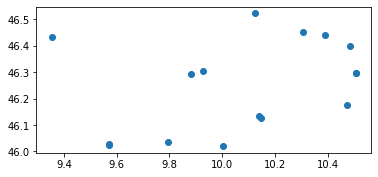

In [ ]:
import geopandas as gpd
from geocube.api.core import make_geocube

df_for_tif = stations_Lombardia_2018.groupby(['Latitude', 'Longitude']).first()
df_for_tif.reset_index(inplace = True)

gdf = gpd.GeoDataFrame(
    df_for_tif,
    geometry=gpd.points_from_xy(df_for_tif.Longitude, df_for_tif.Latitude)
)

gdf.plot()


out_grd = make_geocube(
    vector_data=gdf,
    measurements=["Elevation"],
    resolution=(-0.05, 0.05)
)

out_grd["Elevation"].rio.to_raster("Lombardia_stations_until2018.tif")

## Elevations plot

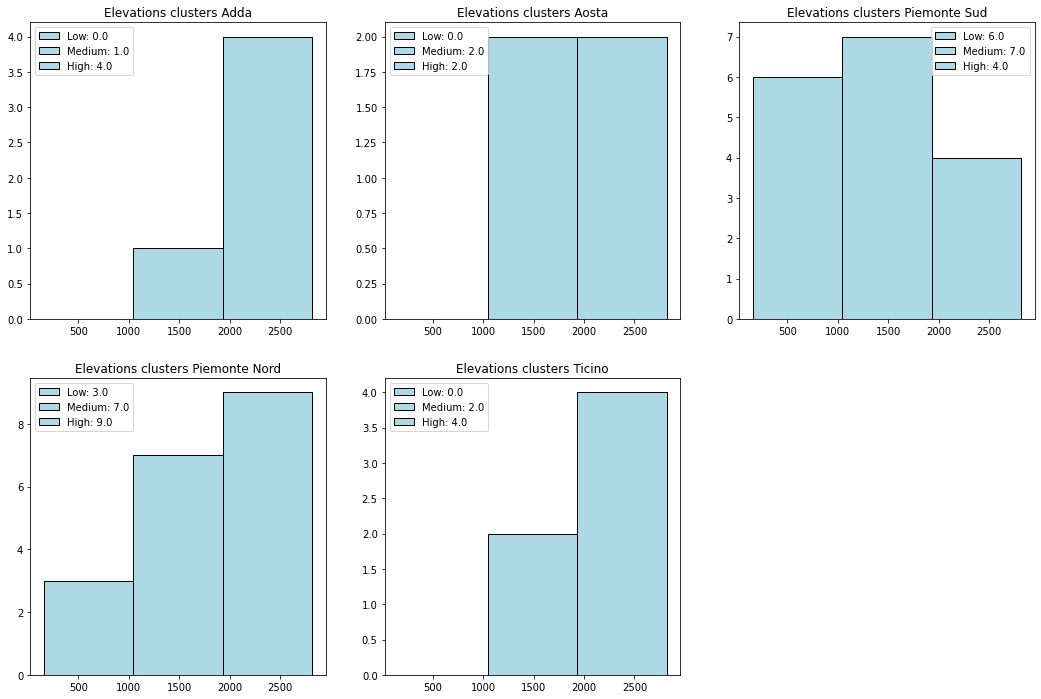

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# assegnare a ciascun valore un cluster (in questo caso, 3 cluster)

region_names = ['Adda', 'Aosta', 'Piemonte Sud', 'Piemonte Nord', 'Ticino']

elevation_Adda = df_stations_entire_range_Adda.groupby('Name').first()['Elevation'].values
elevation_Aosta = df_stations_entire_range_Aosta_valid.groupby('Name').first()['Elevation'].values
elevation_Piemonte_Sud = df_Piemonte_filtered.loc[df_Piemonte_filtered['Associated_region'] == "Piemonte_Sud"]['Elevation']
elevation_Piemonte_Nord = df_Piemonte_filtered.loc[df_Piemonte_filtered['Associated_region'] == "Piemonte_Nord"]['Elevation']
elevation_Ticino = df_Piemonte_filtered.loc[df_Piemonte_filtered['Associated_region'] == "Ticino"]['Elevation']

all_data = np.concatenate([elevation_Adda, elevation_Aosta, elevation_Piemonte_Sud,
                           elevation_Piemonte_Nord, elevation_Ticino])

bin_edges = np.histogram_bin_edges(all_data, bins=3)

cluster_labels = ['Low', 'Medium', 'High']
clustered_data = pd.cut(all_data, bins=bin_edges, labels=cluster_labels)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, arr in enumerate([elevation_Adda, elevation_Aosta, elevation_Piemonte_Sud, elevation_Piemonte_Nord, elevation_Ticino]):
  row = i // 3
  col = i % 3
  counts, bins, patches = axs[row, col].hist(arr, bins=bin_edges, edgecolor='black', color='lightblue')

  for j, patch in enumerate(patches):
      patch.set_label(f'{cluster_labels[j]}: {counts[j]}')
  axs[row, col].legend()
  axs[row, col].set_title(f'Elevations clusters ' + region_names[i])

if len(region_names) < 6:
    fig.delaxes(axs[1, 2])

plt.show()

## Explore snow depth (and SWE) IT-SNOW

https://zenodo.org/record/7034956#.Y77BcuzMLUY

In [ ]:
nc_snow_daily = glob.glob(snow_folder + "IT-SNOW/" + '*.nc')
nc_snow_daily

['snow/IT-SNOW/ITSNOW_HS_201009.nc']

In [ ]:
for path_name in nc_snow_daily:
    features = xarray.open_dataset(path_name)
    features = features['HS']
    #features = features['SWE']
    features.rio.set_spatial_dims(x_dim = "Longitude", y_dim = "Latitude", inplace=True)
    features.rio.to_raster(path_name.replace(".nc", ".tif"))

In [ ]:
tif_snow_daily = glob.glob(snow_folder + "IT-SNOW/" + '*.tif')
tif_snow_daily

In [ ]:
shape_files_dir = "./bacini_shp/"
shape_files = glob.glob(shape_files_dir+'*.shp')
shape_files

['./bacini_shp/Ticino.shp',
 './bacini_shp/Piemonte_Sud.shp',
 './bacini_shp/Piemonte_Nord.shp',
 './bacini_shp/Oglio_Iseo.shp',
 './bacini_shp/Lambro_Olona.shp',
 './bacini_shp/Garda_Mincio.shp',
 './bacini_shp/Adda.shp',
 './bacini_shp/Emiliani1.shp',
 './bacini_shp/Emiliani2.shp',
 './bacini_shp/Dora.shp']

In [ ]:
# the one/ones to cut
shape_files = ['./bacini_shp/Dora.shp']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import mapping
import geopandas as gpd

for tif_name in tif_snow_daily:

    raster = xr.open_rasterio(tif_name)

    for shape_name in shape_files:

        crop_extent = gpd.read_file(shape_name)
        crop_extent = crop_extent.to_crs(epsg='4326')
        raster = raster.rio.set_crs('epsg:4326')
        tiff_clipped = raster.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)
        tiff_clipped.rio.to_raster(tif_name.replace(".tif", "") + shape_name.replace("./bacini_shp/", "_").replace(".shp", "") + '.tif')

In [ ]:
csv_features_folder = "./snow/IT-SNOW/csv_HS/"
regions = ['Piemonte_Sud', 'Piemonte_Nord']
region = 'Piemonte_Sud'

In [ ]:
import datetime

# same function used for temperature and precipitation features
def create_statistics_dataframe(complete_dataframe, allCoord):

    n = 0.6

    # starting from the right date to be aligned with VHI target in aggregations
    START = datetime.datetime.strptime("2010-09-03", "%Y-%m-%d")
    END = datetime.datetime.strptime("2019-12-24", "%Y-%m-%d")
    dates_8days = pd.date_range(start=START, end=END + datetime.timedelta(days=1), freq = '8D')
    years = [date.year for date in dates_8days[1:]]
    # weeks = [date.isocalendar().week for date in dates_8days[1:]]
    weeks = [date.isocalendar()[1] for date in dates_8days[1:]]

    # take only the first 60% of the dataframe and compute the cyclostationary mean for week
    last_training_day = round(len(dates_8days)*n)

    complete_dataframe = complete_dataframe.loc[:, complete_dataframe.columns >= START]

    if allCoord == False:

        means = complete_dataframe.mean(axis=0)
        means_8days = [means[i:i+8].mean() for i in range(0, len(means), 8)]
        statistics = pd.DataFrame({'mean': means_8days, 'year': years, 'week': weeks}, index = dates_8days[1:])

        train_df = statistics[statistics.index <= dates_8days[last_training_day]]

        weekoftheyar_mean = train_df.groupby(['week'])['mean'].mean()
        index = statistics.index
        statistics = pd.merge(statistics, weekoftheyar_mean, how='left', on=['week'],
                              suffixes=['','_weekoftheyear']).set_index(index)

    else:
        # create a multi_index with both coordinates and date
        multi_index_dataframe = pd.concat([complete_dataframe.iloc[:,:1]] * len(dates_8days[1:]),
                                          keys=dates_8days[1:], names=['date'])

        # save mean values for groups of 8 days
        for i in range(0, len(complete_dataframe.columns), 8):
            if i == 0:
                cells_means_8days = complete_dataframe.iloc[:,i:i+8].mean(axis = 1).values
            else:
                cells_means_8days = np.concatenate([cells_means_8days,
                                                    complete_dataframe.iloc[:,i:i+8].mean(axis = 1).values])

        statistics = pd.DataFrame({'mean': cells_means_8days, 'year': np.repeat(years, len(complete_dataframe)),
                                   'week': np.repeat(weeks, len(complete_dataframe))},
                                  index = multi_index_dataframe.index)

        train_df = statistics[statistics.index.get_level_values(0) <= dates_8days[last_training_day]]
        # cyclostationary_means_8days
        weekoftheyar_mean = train_df.groupby(['week', 'y', 'x'])['mean'].mean()
        index = statistics.index
        statistics = pd.merge(statistics, weekoftheyar_mean, how='left', on=['week', 'y', 'x'],
                              suffixes=['','_weekoftheyear']).set_index(index)

    statistics['cyclostationary_mean'] = statistics['mean'] - statistics['mean_weekoftheyear']
    statistics.drop("mean_weekoftheyear", axis='columns', inplace = True)

    return statistics

In [ ]:
import calendar
import datetime

tif_files_dir = "./IT-SNOW/"
csv_files_dir = "./IT-SNOW/csv_HS/"
END = datetime.datetime.strptime("2019-12-24", "%Y-%m-%d")

for region in regions:
    cropped_tif_files = glob.glob(tif_files_dir + '*' + region + '*.tif')
    cropped_tif_files.sort()

    for i, cropped_tif_file in enumerate(cropped_tif_files):

        raster = xr.open_rasterio(cropped_tif_file).drop_vars(["spatial_ref"])
        dataframe = raster.to_dataset('band').to_dataframe()

        # remove useless null values
        dataframe = dataframe.replace(-9999,np.NaN)
        dataframe = dataframe.dropna()

        year = cropped_tif_file[20:24]
        #year = cropped_tif_file[21:25] (for SWE)
        month = cropped_tif_file[24:26]
        #month = cropped_tif_file[25:27] (for SWE)

        if dataframe.empty:
            print("DataFrame of "+ month + " " + year +" of " + region + " is empty!")

        scale_factor = raster.attrs['scale_factor']
        if (scale_factor != 1.0):
            dataframe = dataframe * scale_factor # fix the scale factor

        month_start = datetime.datetime.strptime(year + '-' + month + '-01', "%Y-%m-%d")
        last_day_month = calendar.monthrange(int(year), int(month))[1]
        month_end = datetime.datetime.strptime(year + "-" + month + "-" + str(last_day_month), "%Y-%m-%d")
        days = pd.date_range(start=month_start, end=month_end, freq = 'D')

        if (len(dataframe.columns) > len(days)):
            dataframe = dataframe.iloc[:,: -(len(dataframe.columns) - len(days))]
            print("More days than needed for "+ month + " " + year + " of " + region)

        dataframe.columns = days

        if i == 0:
            complete_dataframe = dataframe
        else:
            complete_dataframe = pd.concat([complete_dataframe, dataframe], axis=1)

    complete_dataframe.replace(np.NaN, 0.0, inplace=True)

    # round coordinates to avoid getting too many values

    complete_dataframe.reset_index(inplace = True)
    complete_dataframe = complete_dataframe.round({'y': 1, 'x': 1})
    complete_dataframe = complete_dataframe.groupby(['y', 'x']).mean()

    complete_dataframe = complete_dataframe.loc[:, complete_dataframe.columns <= END]

    print("DataFrame of "+ region + " completed. Computing means...")

    statistics = create_statistics_dataframe(complete_dataframe, False)
    statistics.to_csv(csv_files_dir + region + "_HS_snow.csv")
    print("CSV of "+ region + " saved.")

### Check coordinates after rounding

In [ ]:
df = pd.read_csv(csv_features_folder + region + "_snow_allCoord.csv")

In [ ]:
# check coordinates location after rounding to the first decimal

import numpy as np
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube

df_for_tif = df
df_for_tif.reset_index(inplace = True)
df_for_tif["tmp"] = [1.0 for i in range(0,len(complete_dataframe))]

gdf = gpd.GeoDataFrame(
    df_for_tif,
    geometry=gpd.points_from_xy(df_for_tif.x, df_for_tif.y)
)

gdf.plot()

geotif_file = "/tmp/raster.tif"
out_grd = make_geocube(
    vector_data=gdf,
    measurements=["tmp"],
    resolution=(-0.1, 0.1)
)

# out_grd["tmp"].rio.to_raster("Piemonte_Nord_check.tif")

### Add features aggregations

In [ ]:
computeAggregations(True, "./IT-SNOW/csv_HS/", "_HS_snow_allCoord.csv", "_aggreg_HS_allCoord.csv")
computeAggregations(False, "./IT-SNOW/csv_HS/", "_HS_snow.csv", "_aggreg_HS.csv")

## Copernicus

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

In [ ]:
grib_snow_daily = glob.glob(snow_folder + "copernicus/" + '*.grib')
grib_snow_daily

['snow/copernicus/2000-2019.grib', 'snow/copernicus/hourly_data.grib']

In [ ]:
features = xarray.open_dataset('snow/copernicus/hourly_data.grib')
features = features['sd']

In [ ]:
features.to_dataframe().groupby('time').nth(4)['sd']

In [ ]:
features.to_dataframe()

number   step  surface  \
time                latitude longitude                           
2000-01-01 00:00:00 47.0     6.00            0 0 days      0.0   
                             6.25            0 0 days      0.0   
                             6.50            0 0 days      0.0   
                             6.75            0 0 days      0.0   
                             7.00            0 0 days      0.0   
...                                        ...    ...      ...   
2000-01-02 23:00:00 43.0     13.00           0 0 days      0.0   
                             13.25           0 0 days      0.0   
                             13.50           0 0 days      0.0   
                             13.75           0 0 days      0.0   
                             14.00           0 0 days      0.0   

                                                valid_time        sd  
time                latitude longitude                                
2000-01-01 00:00:00 47.0     6.00      2000-01-01 00:00:00  0.011985  
                             6.25      2000-01-01 00:00:00  0.023041  
                             6.50      2000-01-01 00:00:00  0.035805  
                             6.75      2000-01-01 00:00:00  0.031737  
                             7.00      2000-01-01 00:00:00  0.024341  
...                                                    ...       ...  
2000-01-02 23:00:00 43.0     13.00     2000-01-02 23:00:00  0.013508  
                             13.25     2000-01-02 23:00:00  0.016340  
                             13.50     2000-01-02 23:00:00  0.004809  
                             13.75     2000-01-02 23:00:00  0.003253  
                             14.00     2000-01-02 23:00:00  0.000000  

[26928 rows x 5 columns]

In [ ]:
for path_name in grib_snow_daily:
    features = xarray.open_dataset(path_name)
    features = features['sd']
    features.rio.set_spatial_dims(x_dim = "longitude", y_dim = "latitude", inplace=True)
    features.rio.to_raster(path_name.replace(".grib", ".tif"))

In [ ]:
tif_files_dir = snow_folder + "copernicus/"
tif_snow_daily = glob.glob(tif_files_dir + '*.tif')
tif_snow_daily

['snow/copernicus/2000-2019.tif',
 'snow/copernicus/Dora.tif',
 'snow/copernicus/Lambro_Olona.tif',
 'snow/copernicus/Oglio_Iseo.tif',
 'snow/copernicus/Garda_Mincio.tif',
 'snow/copernicus/Piemonte_Sud.tif',
 'snow/copernicus/Ticino.tif',
 'snow/copernicus/Piemonte_Nord.tif',
 'snow/copernicus/Emiliani2.tif',
 'snow/copernicus/Emiliani1.tif',
 'snow/copernicus/Adda.tif']

In [8]:
import datetime

# same function used for temperature and precipitation features
def create_statistics_dataframe(complete_dataframe, allCoord):

    n = 0.6

    # starting from the right date to be aligned with VHI target in aggregations
    START = datetime.datetime.strptime("2000-01-03", "%Y-%m-%d")
    END = datetime.datetime.strptime("2019-12-24", "%Y-%m-%d")
    dates_8days = pd.date_range(start=START, end=END + datetime.timedelta(days=1), freq = '8D')
    years = [date.year for date in dates_8days[1:]]
    # weeks = [date.isocalendar().week for date in dates_8days[1:]]
    weeks = [date.isocalendar()[1] for date in dates_8days[1:]]

    # take only the first 60% of the dataframe and compute the cyclostationary mean for week
    last_training_day = round(len(dates_8days)*n)

    complete_dataframe = complete_dataframe.loc[:, complete_dataframe.columns >= START]

    if allCoord == False:

        means = complete_dataframe.mean(axis=0)
        means_8days = [means[i:i+8].mean() for i in range(0, len(means), 8)]
        statistics = pd.DataFrame({'mean': means_8days, 'year': years, 'week': weeks}, index = dates_8days[1:])

        train_df = statistics[statistics.index <= dates_8days[last_training_day]]

        weekoftheyar_mean = train_df.groupby(['week'])['mean'].mean()
        index = statistics.index
        statistics = pd.merge(statistics, weekoftheyar_mean, how='left', on=['week'],
                              suffixes=['','_weekoftheyear']).set_index(index)

    else:
        # create a multi_index with both coordinates and date
        multi_index_dataframe = pd.concat([complete_dataframe.iloc[:,:1]] * len(dates_8days[1:]),
                                          keys=dates_8days[1:], names=['date'])

        # save mean values for groups of 8 days
        for i in range(0, len(complete_dataframe.columns), 8):
            if i == 0:
                cells_means_8days = complete_dataframe.iloc[:,i:i+8].mean(axis = 1).values
            else:
                cells_means_8days = np.concatenate([cells_means_8days,
                                                    complete_dataframe.iloc[:,i:i+8].mean(axis = 1).values])

        statistics = pd.DataFrame({'mean': cells_means_8days, 'year': np.repeat(years, len(complete_dataframe)),
                                   'week': np.repeat(weeks, len(complete_dataframe))},
                                  index = multi_index_dataframe.index)

        train_df = statistics[statistics.index.get_level_values(0) <= dates_8days[last_training_day]]
        # cyclostationary_means_8days
        weekoftheyar_mean = train_df.groupby(['week', 'y', 'x'])['mean'].mean()
        index = statistics.index
        statistics = pd.merge(statistics, weekoftheyar_mean, how='left', on=['week', 'y', 'x'],
                              suffixes=['','_weekoftheyear']).set_index(index)

    statistics['cyclostationary_mean'] = statistics['mean'] - statistics['mean_weekoftheyear']
    statistics.drop("mean_weekoftheyear", axis='columns', inplace = True)

    return statistics

In [9]:
import calendar
import datetime

tif_files_dir = snow_folder + "copernicus/"
csv_files_dir = snow_folder + "copernicus/csv_sd/"
START_data = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d")
END_data = datetime.datetime.strptime("2019-12-31", "%Y-%m-%d")
last_useful_date = datetime.datetime.strptime("2019-12-24", "%Y-%m-%d")

only_relevant_coord = False

#regions = ['Ticino', 'Adda', 'Oglio_Iseo', 'Dora', 'Piemonte_Sud', 'Piemonte_Nord',
#          'Emiliani1', 'Emiliani2', 'Garda_Mincio']

regions = ["Lambro_Olona"]

for region in regions:

    raster = xr.open_rasterio(tif_files_dir + region + '.tif').drop_vars(["spatial_ref"])
    dataframe = raster.to_dataset('band').to_dataframe()

    # remove useless coords with only zero values
    filtered_df = dataframe.loc[(dataframe != 0).any(axis=1)]

    if (only_relevant_coord):
      # compute the percentage of values different from 0.0 for each row
      percentage = (filtered_df != 0.0).sum(axis=1) / filtered_df.shape[1]
      # filter rows with a percentage less than 40%
      filtered_rows = percentage[percentage >= 0.4].index
      filtered_df = filtered_df.loc[filtered_rows]

      csv_files_dir = snow_folder + "copernicus/csv_sd_relevant_coords/"

    scale_factor = raster.attrs['scale_factor']
    if (scale_factor != 1.0):
        filtered_df = filtered_df * scale_factor # fix the scale factor

    days = pd.date_range(start=START_data, end=END_data, freq='D')

    filtered_df.columns = days
    filtered_df = filtered_df.loc[:, filtered_df.columns <= last_useful_date]

    print("DataFrame of "+ region + " completed. Computing means...")

    statistics_allCoord = create_statistics_dataframe(filtered_df, True)
    statistics_allCoord.to_csv(csv_files_dir + region + "_sd_allCoord.csv")

    statistics = create_statistics_dataframe(filtered_df, False)
    statistics.to_csv(csv_files_dir + region + "_sd.csv")

    print("CSV of "+ region + " saved.")

DataFrame of Lambro_Olona completed. Computing means...
CSV of Lambro_Olona saved.


In [10]:
import calendar
import datetime

tif_files_dir = snow_folder + "copernicus/"
csv_files_dir = snow_folder + "copernicus/csv_sd/"
START_data = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d")
END_data = datetime.datetime.strptime("2019-12-31", "%Y-%m-%d")
last_useful_date = datetime.datetime.strptime("2019-12-24", "%Y-%m-%d")

only_relevant_coord = True

#regions = ['Ticino', 'Adda', 'Oglio_Iseo', 'Dora', 'Piemonte_Sud', 'Piemonte_Nord',
#          'Emiliani1', 'Emiliani2', 'Garda_Mincio']
regions = ['Lambro_Olona']

for region in regions:

    raster = xr.open_rasterio(tif_files_dir + region + '.tif').drop_vars(["spatial_ref"])
    dataframe = raster.to_dataset('band').to_dataframe()

    # remove useless coords with only zero values
    filtered_df = dataframe.loc[(dataframe != 0).any(axis=1)]

    if (only_relevant_coord):
      # compute the percentage of values different from 0.0 for each row
      percentage = (filtered_df != 0.0).sum(axis=1) / filtered_df.shape[1]
      # filter rows with a percentage less than 40%
      filtered_rows = percentage[percentage >= 0.4].index
      filtered_df = filtered_df.loc[filtered_rows]

      csv_files_dir = snow_folder + "copernicus/csv_sd_relevant_coords/"

    scale_factor = raster.attrs['scale_factor']
    if (scale_factor != 1.0):
        filtered_df = filtered_df * scale_factor # fix the scale factor

    days = pd.date_range(start=START_data, end=END_data, freq='D')

    filtered_df.columns = days
    filtered_df = filtered_df.loc[:, filtered_df.columns <= last_useful_date]

    print("DataFrame of "+ region + " completed. Computing means...")

    statistics_allCoord = create_statistics_dataframe(filtered_df, True)
    statistics_allCoord.to_csv(csv_files_dir + region + "_sd_allCoord.csv")

    statistics = create_statistics_dataframe(filtered_df, False)
    statistics.to_csv(csv_files_dir + region + "_sd.csv")

    print("CSV of "+ region + " saved.")

DataFrame of Lambro_Olona completed. Computing means...
CSV of Lambro_Olona saved.


In [12]:
regions = ['Ticino', 'Adda', 'Oglio_Iseo', 'Dora', 'Piemonte_Sud', 'Piemonte_Nord',
          'Emiliani1', 'Emiliani2', 'Garda_Mincio', 'Lambro_Olona']

for region in regions:
  computeAggregations(True, "./snow/copernicus/csv_sd/", "_sd_allCoord.csv", "_aggreg_sd_allCoord.csv",
                      region, "./snow/copernicus/csv_sd/")

  computeAggregations(False, "./snow/copernicus/csv_sd/", "_sd.csv", "_aggreg_sd.csv",
                      region, "./snow/copernicus/csv_sd/")

  computeAggregations(True, "./snow/copernicus/csv_sd_relevant_coords/", "_sd_allCoord.csv", "_aggreg_sd_allCoord.csv",
                      region, "./snow/copernicus/csv_sd_relevant_coords/")

  computeAggregations(False, "./snow/copernicus/csv_sd_relevant_coords/", "_sd.csv", "_aggreg_sd.csv",
                      region, "./snow/copernicus/csv_sd_relevant_coords/")

In [35]:
csv_features_folder = "./features_allvalues/snow/copernicus/"
csv_features_folder_rel_coords = "./features_allvalues/snow/copernicus/relevant_coords/"
csv_name = "_aggreg_sd_allCoord.csv"

In [42]:
import os
regions = ['Ticino', 'Adda', 'Oglio_Iseo', 'Dora', 'Piemonte_Sud', 'Piemonte_Nord',
           'Emiliani1', 'Emiliani2', 'Garda_Mincio']
for region in regions:
  df = pd.read_csv(csv_features_folder + region + csv_name)
  print("Number of coordinates for ", region, " :", str(len(df.groupby(['x', 'y']))))

print("\n")

for region in regions:
  if os.path.isfile(csv_features_folder_rel_coords + region + csv_name):
    df = pd.read_csv(csv_features_folder_rel_coords + region + csv_name)
    print("Number of coordinates for ", region, " after removing nearly always zero coords:", str(len(df.groupby(['x', 'y']))))

Number of coordinates for  Ticino  : 16
Number of coordinates for  Adda  : 13
Number of coordinates for  Oglio_Iseo  : 10
Number of coordinates for  Dora  : 6
Number of coordinates for  Piemonte_Sud  : 21
Number of coordinates for  Piemonte_Nord  : 12
Number of coordinates for  Emiliani1  : 21
Number of coordinates for  Emiliani2  : 17
Number of coordinates for  Garda_Mincio  : 11


Number of coordinates for  Ticino  after removing nearly always zero coords: 11
Number of coordinates for  Adda  after removing nearly always zero coords: 7
Number of coordinates for  Oglio_Iseo  after removing nearly always zero coords: 2
Number of coordinates for  Dora  after removing nearly always zero coords: 6
Number of coordinates for  Piemonte_Sud  after removing nearly always zero coords: 3
Number of coordinates for  Piemonte_Nord  after removing nearly always zero coords: 5
Number of coordinates for  Garda_Mincio  after removing nearly always zero coords: 1
